### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3,
    "V_g_profile":False,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



In [4]:
# # Create a dict with all important settings

# data_vessel = {
#     "env": None,
#     "name": 'Vessel M6',
#     "route": None,
#     "geometry": None,
#     "v": None,  # m/s
#     "V_g_ave":3,
#     "V_g_profile":False,
#     "type": None,
#     "B": 10.5,
#     "L": 155.75,
#     "H_e": None, 
#     "H_f": None, 
#     "T": 2,
#     "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
#     "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
#     "payload":None,
#     "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
#     "P_installed": 780.0,   
#     "P_tot_given": None, # kW
#     "P_tot_given_profile":False,
#     "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
#     "sailing_on_power": False,
#     "sailing_upstream":False,
#     "wind_influence": False,
#     "P_hotel_perc": 0,
#     "P_hotel": None, # None: calculate P_hotel from percentage
#     "x": 1,# number of propellers
#     "L_w": 2.0 ,
#     "C_B":0.85, 
#     "C_year": 1961,
# }             



In [5]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [6]:
V_s = np.linspace(0, 7, 801)          # ship sailing speeds to water, (m/s)
# V_s_km_h =  np.linspace(3,20,35)

h_0 = [3,3.3,4.2,5,5.5,8,10.6,20]                 # water depths,(m)
T = [2]   # draught


### prepare input matrix for calculation

In [7]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(T, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T,h_0,V_s
6403,2,20.0,6.96500
6404,2,20.0,6.97375
6405,2,20.0,6.98250
6406,2,20.0,6.99125
6407,2,20.0,7.00000


### Run OpenTNSim to Calculate resistance, required power and emissions 

In [8]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    
    data_vessel_i = data_vessel.copy()
    
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T']
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    # h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    # print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s, h_0)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    (eta_D, P_propulsion,P_tot,P_given) = vessel.calculate_total_power_required(V_s, h_0)

    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f'] = R_f
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['eta_D'] = eta_D
    result['P_d'] = P_propulsion

    results.append(result)

0it [00:00, ?it/s]c:\users\manjiang\opentnsim-energy\opentnsim\energy.py:690: RuntimeWarning:

divide by zero encountered in log10

c:\users\manjiang\opentnsim-energy\opentnsim\energy.py:696: RuntimeWarning:

divide by zero encountered in log10

c:\users\manjiang\opentnsim-energy\opentnsim\energy.py:698: RuntimeWarning:

divide by zero encountered in log10

c:\users\manjiang\opentnsim-energy\opentnsim\energy.py:705: RuntimeWarning:

divide by zero encountered in log10

c:\users\manjiang\opentnsim-energy\opentnsim\energy.py:708: RuntimeWarning:

divide by zero encountered in log10

c:\users\manjiang\opentnsim-energy\opentnsim\energy.py:709: RuntimeWarning:

divide by zero encountered in log10

c:\users\manjiang\opentnsim-energy\opentnsim\energy.py:709: RuntimeWarning:

divide by zero encountered in double_scalars

c:\users\manjiang\opentnsim-energy\opentnsim\energy.py:734: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\manjiang\opentnsim-energy\opentnsim\energy.p

In [9]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(50)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,eta_D,P_d,V_s_km
0,2.0,3.0,0.00000,780.0,NaN,NaN,NaN,NaN,0.000000,NaN,0.4,NaN,0.0000
1,2.0,3.0,0.00875,780.0,0.000267,0.000328,0.000033,0.000000e+00,0.000038,0.000400,0.4,0.000009,0.0315
2,2.0,3.0,0.01750,780.0,0.000896,0.001101,0.000112,0.000000e+00,0.000154,0.001366,0.4,0.000060,0.0630
3,2.0,3.0,0.02625,780.0,0.001831,0.002248,0.000229,0.000000e+00,0.000346,0.002823,0.4,0.000185,0.0945
4,2.0,3.0,0.03500,780.0,0.003046,0.003740,0.000381,4.226198e-271,0.000615,0.004736,0.4,0.000414,0.1260
5,2.0,3.0,0.04375,780.0,0.004527,0.005559,0.000566,3.555557e-221,0.000961,0.007085,0.4,0.000775,0.1575
6,2.0,3.0,0.05250,780.0,0.006263,0.007690,0.000783,3.317942e-187,0.001383,0.009856,0.4,0.001294,0.1890
7,2.0,3.0,0.06125,780.0,0.008245,0.010124,0.001031,1.581544e-162,0.001882,0.013037,0.4,0.001996,0.2205
8,2.0,3.0,0.07000,780.0,0.010467,0.012851,0.001308,9.487097e-144,0.002458,0.016617,0.4,0.002908,0.2520
9,2.0,3.0,0.07875,780.0,0.012921,0.015865,0.001615,5.857731e-129,0.003111,0.020590,0.4,0.004054,0.2835


In [10]:
plot_df.tail(50)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,eta_D,P_d,V_s_km
6358,2.0,20.0,6.57125,780.0,34.988458,42.958573,4.373557,24.999454,15.165223,87.496806,0.48,1197.840394,23.6565
6359,2.0,20.0,6.58000,780.0,35.075560,43.065515,4.384445,25.060944,15.196936,87.707840,0.48,1202.328308,23.6880
6360,2.0,20.0,6.58875,780.0,35.162763,43.172582,4.395345,25.130207,15.228657,87.926792,0.48,1206.932609,23.7195
6361,2.0,20.0,6.59750,780.0,35.250067,43.279774,4.406258,25.207804,15.260385,88.154221,0.48,1211.661408,23.7510
6362,2.0,20.0,6.60625,780.0,35.337472,43.387089,4.417184,25.294263,15.292121,88.390657,0.48,1216.522456,23.7825
6363,2.0,20.0,6.61500,780.0,35.424979,43.494529,4.428122,25.390084,15.323864,88.636599,0.48,1221.523137,23.8140
6364,2.0,20.0,6.62375,780.0,35.512586,43.602093,4.439073,25.495738,15.355614,88.892518,0.48,1226.670456,23.8455
6365,2.0,20.0,6.63250,780.0,35.600295,43.709781,4.450037,25.611664,15.387371,89.158854,0.48,1231.971033,23.8770
6366,2.0,20.0,6.64125,780.0,35.688105,43.817594,4.461013,25.738272,15.419134,89.436014,0.48,1237.431097,23.9085
6367,2.0,20.0,6.65000,780.0,35.776017,43.925531,4.472002,25.875939,15.450905,89.724377,0.48,1243.056475,23.9400


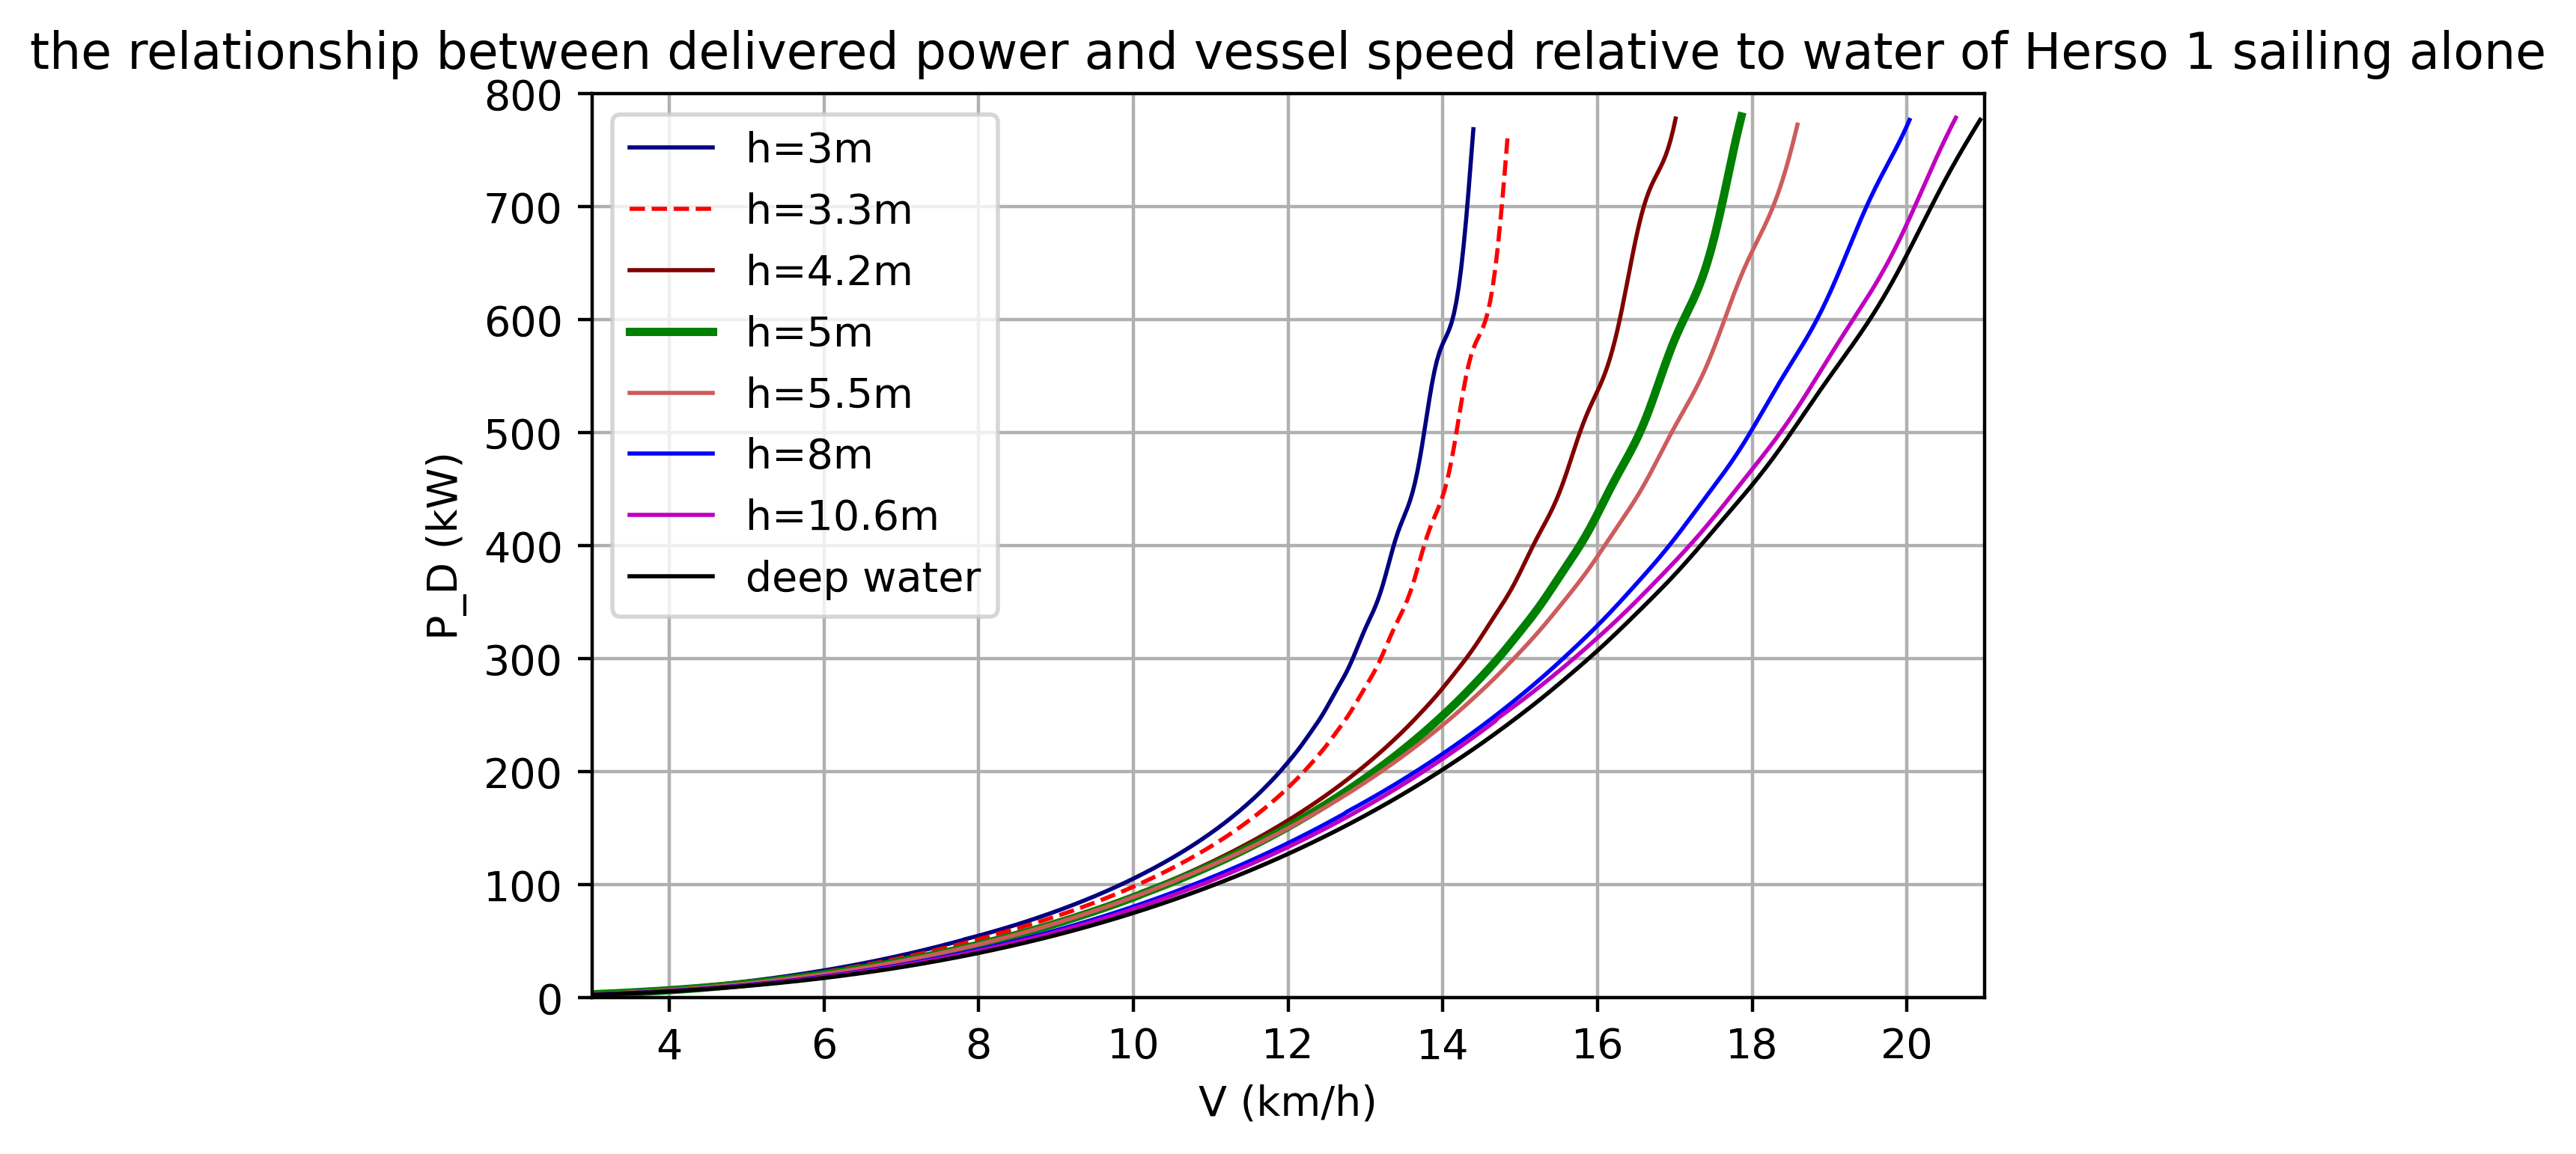

In [11]:
selected_h_3 = plot_df.query('h_0 == 3 & P_d < P_installed')
selected_h_3_3 = plot_df.query('h_0 == 3.3 & P_d < P_installed')
selected_h_4_2 = plot_df.query('h_0 == 4.2 & P_d < P_installed')
selected_h_5 = plot_df.query('h_0 == 5 & P_d < P_installed')
selected_h_5_5 = plot_df.query('h_0 == 5.5 & P_d < P_installed')
selected_h_8 = plot_df.query('h_0 == 8 & P_d < P_installed')
selected_h_10_6 = plot_df.query('h_0 == 10.6 & P_d < P_installed')
selected_h_deep = plot_df.query('h_0 == 20 & P_d < P_installed')
plt.figure(dpi=400)
plt.plot(selected_h_3['V_s_km'],selected_h_3['P_d'], 'navy', linewidth = 1.0)
plt.plot(selected_h_3_3['V_s_km'],selected_h_3_3['P_d'], 'r', linewidth = 1.0, linestyle = 'dashed')
plt.plot(selected_h_4_2['V_s_km'],selected_h_4_2['P_d'], 'maroon', linewidth = 1.0)
plt.plot(selected_h_5['V_s_km'],selected_h_5['P_d'], 'g', linewidth = 2.0)
plt.plot(selected_h_5_5['V_s_km'],selected_h_5_5['P_d'], 'indianred', linewidth = 1)
plt.plot(selected_h_8['V_s_km'],selected_h_8['P_d'], 'b', linewidth = 1.0)
plt.plot(selected_h_10_6['V_s_km'],selected_h_10_6['P_d'], 'm', linewidth = 1.0)
plt.plot(selected_h_deep['V_s_km'],selected_h_deep['P_d'], 'k', linewidth = 1)

plt.xlabel('V (km/h)')
plt.ylabel('P_D (kW)')
plt.legend(['h=3m','h=3.3m','h=4.2m','h=5m','h=5.5m','h=8m','h=10.6m','deep water'])
plt.grid()
plt.xlim(3, 21)
plt.ylim(0,800)
plt.title('the relationship between delivered power and vessel speed relative to water of Herso 1 sailing alone');

In [12]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)


In [13]:
R=vessel.calculate_total_resistance(v=4, h_0=5)
P = vessel.calculate_total_power_required(v=4, h_0=5)
P

(0.42, 276.5395438245427, 276.5395438245427, 276.5395438245427)

In [14]:
V_w1 = opentnsim.strategy.power2v(vessel, h_0=5,power_applied=585, upperbound=8)
V_w1

4.7264343636659945